### IMPORT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab 
import scipy.stats as stats
import seaborn as sns
import sqlite3
import ipywidgets as widgets
from IPython.display import IFrame
from ipywidgets import interact, interactive

#### WHAT IS PODCAST?

A podcast is a program made available in digital format for download over the Internet. For example, an episodic series of digital audio or video files that a user can download to a personal device to listen to at a time of their choosing<sup>1</sup>

[1]: [Source: Wikipedia](https://en.wikipedia.org/wiki/Podcast)

#### WHAT'S ON THIS DATASET?

Generally - more than 1.3M text reviews and ratings for Apple Podcasts in a period of 2005-12 - 2022-06

#### OBJECTIVE

Exploratory data analysis of reviews, ratings and categories. We'll try to find some correlations between variables, and do some statistical inference by defining target population, hypotheses etc.

## Data Preprocessing

In [2]:
def title_and_labels(title, x_label, y_label):
    ''' Defining fontsize for plots '''
    plt.title(title, fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)

In [3]:
# connect the dataset and list available tables inside dataset
con = sqlite3.connect("database.sqlite")

pd.read_sql('''SELECT name
               FROM sqlite_master
               WHERE type = 'table'
               ;''', con)

,name
0,runs
1,podcasts
2,categories
3,reviews


In [4]:
# form pandas datasets from tables
runs_df = pd.read_sql_query('SELECT * FROM runs', con)
podcasts_df = pd.read_sql_query('SELECT * FROM podcasts', con)
categories_df = pd.read_sql_query('SELECT * FROM categories', con)
reviews_df = pd.read_sql_query('SELECT * FROM reviews', con)

In [5]:
runs_df.head()

,run_at,max_rowid,reviews_added
0,2021-05-10 02:53:00,3266481,1215223
1,2021-06-06 21:34:36,3300773,13139
2,2021-07-02 18:04:55,3329699,11561
3,2021-08-01 17:54:42,3360315,11855
4,2021-09-02 18:00:30,3390165,11714


In [6]:
podcasts_df.head()

,podcast_id,itunes_id,slug,itunes_url,title
0,a00018b54eb342567c94dacfb2a3e504,1313466221,scaling-global,https://podcasts.apple.com/us/podcast/scaling-...,Scaling Global
1,a00043d34e734b09246d17dc5d56f63c,158973461,cornerstone-baptist-church-of-orlando,https://podcasts.apple.com/us/podcast/cornerst...,Cornerstone Baptist Church of Orlando
2,a0004b1ef445af9dc84dad1e7821b1e3,139076942,mystery-dancing-in-the-dark,https://podcasts.apple.com/us/podcast/mystery-...,Mystery: Dancing in the Dark
3,a00071f9aaae9ac725c3a586701abf4d,1332508972,kts-money-matters,https://podcasts.apple.com/us/podcast/kts-mone...,KTs Money Matters
4,a000aa69852b276565c4f5eb9cdd999b,1342447811,speedway-soccer,https://podcasts.apple.com/us/podcast/speedway...,Speedway Soccer


In [7]:
categories_df.head()

,podcast_id,category
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts
1,c61aa81c9b929a66f0c1db6cbe5d8548,arts-performing-arts
2,c61aa81c9b929a66f0c1db6cbe5d8548,music
3,ad4f2bf69c72b8db75978423c25f379e,arts
4,ad4f2bf69c72b8db75978423c25f379e,arts-design


In [8]:
reviews_df.head()

,podcast_id,title,content,rating,author_id,created_at
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24T12:05:16-07:00
1,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,F6BF5472689BD12,2018-05-09T18:14:32-07:00
2,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1,1AB95B8E6E1309E,2019-06-11T14:53:39-07:00
3,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,I find Tedx talks very inspirational but I oft...,5,11BB760AA5DEBD1,2018-05-31T13:08:09-07:00
4,ad4f2bf69c72b8db75978423c25f379e,👍👍👍👍,"I love this podcast, it is so good.",5,D86032C8E57D15A,2019-06-19T13:56:05-07:00


In [9]:
pd.read_sql_query(''' SELECT 
                          COUNT(DISTINCT podcast_id) AS number_of_distinct_podcasts
                      FROM categories
                      ''', con)

,number_of_distinct_podcasts
0,54287


There is in total `54287` different Podcasts in this dataset

In [10]:
pd.read_sql_query(''' SELECT 
                          COUNT(DISTINCT category) AS number_of_distinct_categories
                      FROM categories
                      ''', con)

,number_of_distinct_categories
0,110


Podcasts are categorized in a total of **110** different categories.

Since the categories are quite small, let's try to group them under a common theme.

In [11]:
grouped_categories_df = pd.read_sql_query(''' SELECT DISTINCT
                                                    c.podcast_id,
                                                    c.category as distinct_cat,
                                                    CASE
                                                        WHEN c.category LIKE '%sports%' THEN 'sports'
                                                        WHEN c.category LIKE '%business%' THEN 'business'
                                                        WHEN c.category LIKE '%science%' THEN 'science'
                                                        WHEN c.category LIKE '%education%' THEN 'education'
                                                        WHEN c.category LIKE '%kids%' THEN 'kids'
                                                        WHEN c.category LIKE '%fiction%' THEN 'fiction'
                                                        WHEN c.category LIKE '%health%' THEN 'health'
                                                        WHEN c.category LIKE '%leisure%' THEN 'leisure'
                                                        WHEN c.category LIKE '%arts%' THEN 'arts'
                                                        WHEN c.category LIKE '%film%' THEN 'tv-film'
                                                        WHEN c.category LIKE '%news%' THEN 'news'
                                                        WHEN c.category LIKE '%comedy%' THEN 'comedy'
                                                        WHEN c.category LIKE '%society-culture%' THEN 'society-culture'
                                                        WHEN c.category LIKE '%music%' THEN 'music'
                                                        WHEN c.category LIKE '%technology%' THEN 'technology'
                                                        WHEN c.category LIKE '%crime%' THEN 'crime'
                                                        WHEN c.category LIKE '%history%' THEN 'history'
                                                        WHEN c.category LIKE '%government%' THEN 'government'
                                                        WHEN c.category LIKE '%hinduism%' OR
                                                             c.category LIKE '%spirituality%' OR
                                                             c.category LIKE '%islam%' OR
                                                             c.category LIKE '%religion%' OR
                                                             c.category LIKE '%christianity%' OR
                                                             c.category LIKE '%buddhism%' OR
                                                             c.category LIKE '%judaism%' THEN 'religion' END AS category
                                                FROM categories AS c;''', con)

In [12]:
grouped_categories_df.head()

,podcast_id,distinct_cat,category
0,a00018b54eb342567c94dacfb2a3e504,business,business
1,a00043d34e734b09246d17dc5d56f63c,christianity,religion
2,a00043d34e734b09246d17dc5d56f63c,religion-spirituality,religion
3,a0004b1ef445af9dc84dad1e7821b1e3,religion-spirituality,religion
4,a0004b1ef445af9dc84dad1e7821b1e3,spirituality,religion


In [13]:
pd.DataFrame({'distinct_cat': grouped_categories_df['distinct_cat'].nunique(),
              'grouped_cat': grouped_categories_df['category'].nunique()}, index=[0])

,distinct_cat,grouped_cat
0,110,19


Now we have only **19** grouped categories

## EDA

Some Podcasts belongs to more than one category. The figure below shows the distribution of Podcast by the number of categories they are assigned. Podcasts usually fall into one or two categories. Other occasions are rare.

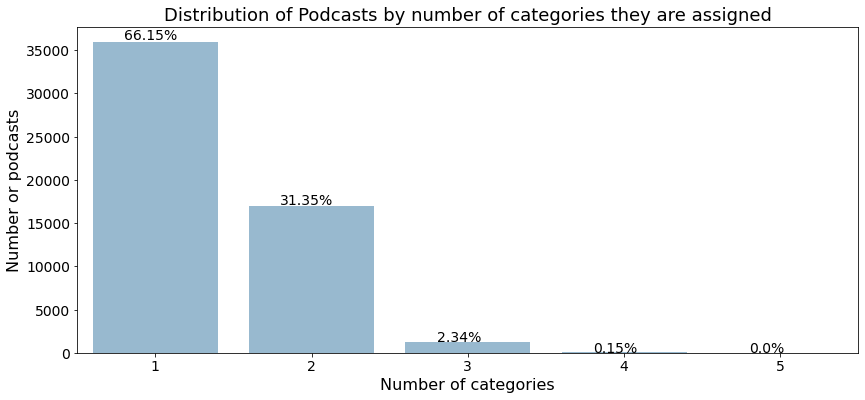

In [14]:
plt.figure(figsize=(14,6))

graph = sns.countplot(x=grouped_categories_df.groupby(['podcast_id'])['category'].nunique(), color='#1F77B4', alpha=0.5)
for patch in graph.patches:
    width = patch.get_width()
    height = patch.get_height()
    x, y = patch.get_xy()
    label = round(patch.get_height()/len(grouped_categories_df.groupby(['podcast_id'])['category'].nunique())*100, 2)
    plt.text(
        x+width/4,
        y+height*1.01,
        str(label)+'%',
        fontsize=14)

title_and_labels(
    title = "Distribution of Podcasts by number of categories they are assigned",
    x_label = "Number of categories",
    y_label = "Number or podcasts"
)

plt.show()

This dataset consist of more than **1.3M** Podcast reviews that are written in a period of **2005-12 - 2022-06**.

Below is the distribution of reviews written per year, but it will not include years on the both ends as data from it is incomplete.

We see that with every year Podcasts were getting more popular, thus means more listeners, thus means more reviews.

In [15]:
reviews_per_year = pd.read_sql_query(''' SELECT 
                                             strftime('%Y', created_at) AS year,
                                             COUNT(strftime('%Y', created_at)) AS no_reviews_per_year
                                         FROM reviews
                                         WHERE strftime('%Y', created_at) BETWEEN '2006' AND '2021'
                                         GROUP BY 1
                                         ;''', con)

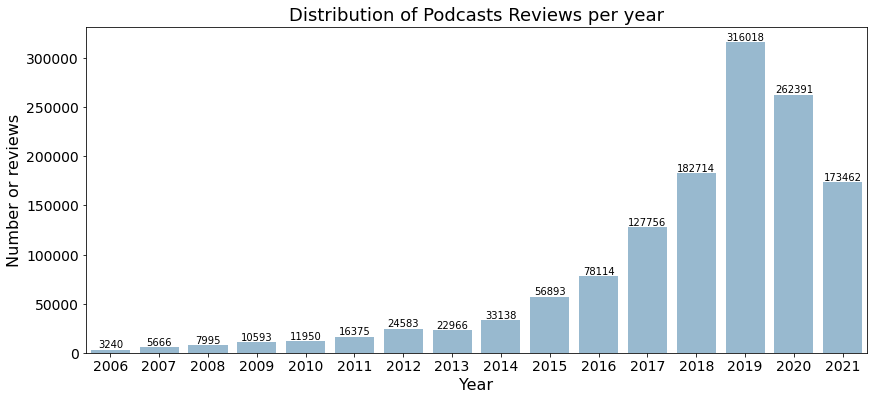

In [16]:
plt.figure(figsize=(14,6))
graph = sns.barplot(x=reviews_per_year['year'], y=reviews_per_year['no_reviews_per_year'], color='#1F77B4', alpha=0.5)
graph.bar_label(graph.containers[0])

title_and_labels(
    title = "Distribution of Podcasts Reviews per year",
    x_label = "Year",
    y_label = "Number or reviews"
)

plt.show()

Now let's see distribution of Podcast by their categories. Which categories are the largest?

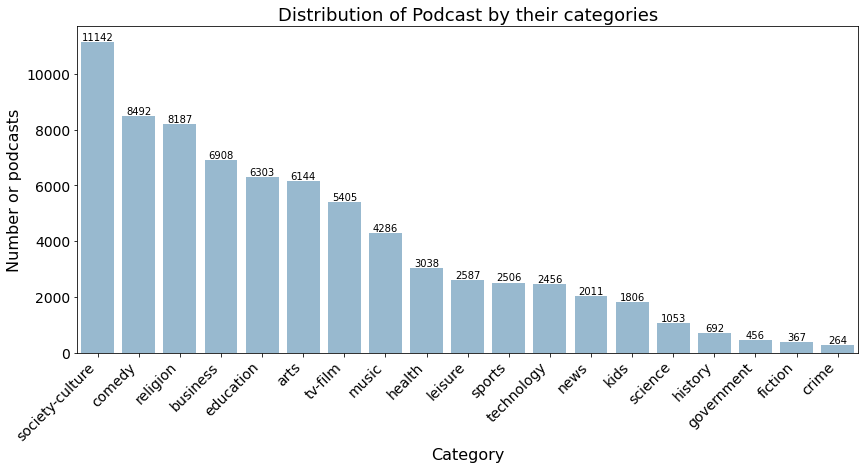

In [17]:
grouped_podcasts_count = grouped_categories_df[['category', 'podcast_id']].groupby(['category'], as_index=False).nunique().sort_values(by='podcast_id', ascending=False)

plt.figure(figsize=(14,6))
graph = sns.barplot(x=grouped_podcasts_count['category'], y=grouped_podcasts_count['podcast_id'], color='#1F77B4', alpha=0.5)
graph.bar_label(graph.containers[0])

graph.set_xticklabels(
    graph.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize=14)

title_and_labels(
    title = "Distribution of Podcast by their categories",
    x_label = "Category",
    y_label = "Number or podcasts"
)

plt.show()

Does this means these categories are the most liked by the listeners? Let's find out.

First, take a look to a distribution of word frequency in Podcast reviews. There is no easy function in SQL to count words in string thus we will assume that words inside the review are separated by one space, and the number of words will be number of spaces + 1.

In [18]:
words_per_review = pd.read_sql_query(''' SELECT 
                                             (LENGTH(content) - LENGTH(REPLACE(content," ","")) + 1) AS review_len
                                         FROM reviews
                                         ;''', con)

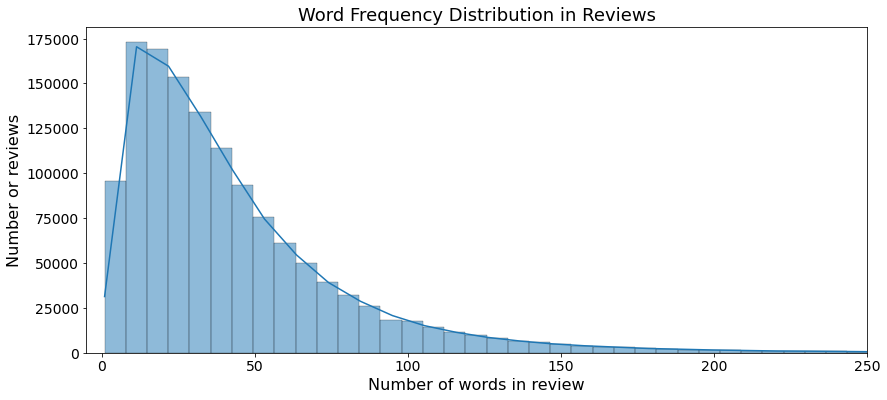

In [19]:
plt.figure(figsize = (14,6))
sns.histplot(words_per_review, bins = 300, color='#1F77B4', kde=True, legend=False)

title_and_labels(
    title = "Word Frequency Distribution in Reviews",
    x_label = "Number of words in review",
    y_label = "Number or reviews")

# There are very few outliers with a 2000+ words in review, thus we hide it by setting the limit on X axis
plt.xlim([-5, 250])
plt.show()

We see a right skewed distribution were most of the reviews are around 25-40 words in length.

Now we'll transform the ratings of Podcasts to sentiments of value **1 and 0**. If rating is **above 3** we will consider it as **1 (positive)** else **0 (negative)**. Then we will see if the length of the review correlates with the positivity/negativity of the review.

In [20]:
review_len_rating_corr = pd.read_sql_query(''' SELECT
                                                   (LENGTH(content) - LENGTH(REPLACE(content," ",""))+1) AS review_len,
                                                   CASE
                                                       WHEN rating > 3 THEN 1 ELSE 0 END AS sentiment
                                               FROM reviews
                                               ;''', con)

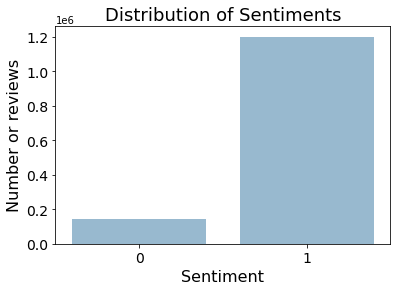

In [21]:
graph = sns.countplot(x=review_len_rating_corr['sentiment'], color='#1F77B4', alpha=0.5)

title_and_labels(
    title = "Distribution of Sentiments",
    x_label = "Sentiment",
    y_label = "Number or reviews")

plt.show()

In [22]:
pos_mean = review_len_rating_corr['review_len'][review_len_rating_corr['sentiment'] == 1].mean()
neg_mean = review_len_rating_corr['review_len'][review_len_rating_corr['sentiment'] == 0].mean()

print(f'Positive review length mean: {pos_mean} Negative review length mean: {neg_mean}')

Positive review length mean: 42.55300411344375 Negative review length mean: 57.07122745814391


In [23]:
review_len_rating_corr.corr()

,review_len,sentiment
review_len,1.000000,-0.102743
sentiment,-0.102743,1.000000


The above results show us that absolutely most of the reviews are Positive. Longer reviews might be more Negative, since the correlation to the lenght is <0, but it is very weak to no correlation.

Now by having positive sentiment count for each Podcast category we can calculate the **positivity rate** (range from 0.0 - 1.0) and let's see what categories are the most successfull.
The most recent category in this dataset is `crime`, which appeared in 2015. Thus to avoid possible bias we'll take only those Podcasts (samples) that has at least **30** reviews and for the period of 2016-2021

In [24]:
positivity_rate = pd.read_sql_query(''' SELECT 
                                            sub.podcast_id,
                                            sub.number_of_reviews,
                                            sub.pos_sentiment,
                                            sub.neg_sentiment,
                                            sub.year,
                                            CAST(sub.pos_sentiment as FLOAT)/sub.number_of_reviews as positivity_rate
                                        FROM (
                                            SELECT
                                                r.podcast_id,
                                                COUNT(r.author_id) AS number_of_reviews,
                                                strftime('%Y', r.created_at) AS year,
                                                COUNT(CASE WHEN r.rating > 3 THEN 1 END) AS pos_sentiment,
                                                COUNT(CASE WHEN r.rating <= 3 THEN 0 END) AS neg_sentiment
                                            FROM reviews as r
                                            WHERE strftime('%Y', r.created_at) BETWEEN '2016' AND '2021'
                                            GROUP BY 1
                                        ) as sub
                                        JOIN categories as c
                                        ON sub.podcast_id = c.podcast_id
                                        ORDER BY sub.number_of_reviews DESC
                                        ;''', con)

In [25]:
positivity_rate = positivity_rate.merge(grouped_categories_df[['podcast_id', 'category']], how='inner', on='podcast_id').drop_duplicates(keep='first')

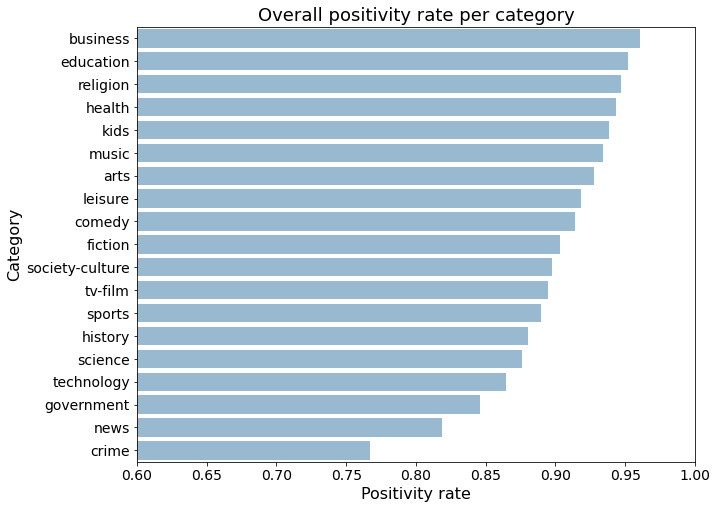

In [26]:
positivity_rate = positivity_rate[positivity_rate['number_of_reviews'] >=30].groupby(['category']).agg({'positivity_rate':'mean'}).sort_values(by='positivity_rate', ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(data=positivity_rate.transpose(), color='#1F77B4', alpha=0.5, orient='h')

title_and_labels(
    title='Overall positivity rate per category',
    x_label='Positivity rate',
    y_label='Category'
)
plt.xlim([0.6, 1.0])
plt.show()

Now we can see that the most succesfull Podcasts are of `business, education, religion, health` categories with a highest positivity rate, while `government, news`  has the lowest ones with `crime` sitting at the bottom below 0.8. Thus means that more then **20%** of all reviews are negative.

Let's see now the spread of users listening for Podcasts of different categories.

What is in an average count of different categories users are listening?

In [27]:
reviews_with_cat = reviews_df.merge(grouped_categories_df[['podcast_id', 'category']], how='left', on='podcast_id')
reviews_with_cat.groupby(['author_id']).agg({'category': 'nunique'}).describe()

,category
count,997880.000000
mean,1.717600
std,0.974309
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,18.000000


We see that on average users listen for podcasts of ~2 different categories, but it must be said, that this data is slightly biased because some Podcasts as showed earlier in the analysis belongs to more than 1 category.

However, for promotional purposes, an analysis could be done to show the distribution of categories among listeners. that is, to find out what other categories are listened to by certain groups of listeners.

In [28]:
user_dataset = pd.DataFrame(reviews_with_cat.groupby(['author_id', 'category']).agg({'rating': 'mean'}).unstack())
user_dataset.index.name = (None)
user_dataset.columns.name = (None, None)
user_dataset.columns = user_dataset.columns.droplevel()

In [29]:
categories = list(user_dataset.columns)

categories_dropdown = widgets.Dropdown(
    options=categories,
    value=categories[1],
    description='Category:'
)

In [30]:
def create_scatter(category):
    with plt.style.context("seaborn-whitegrid"):
        filtered = pd.DataFrame({'count': user_dataset[:][user_dataset[category].notna()].agg('count'),
                                 'rating': user_dataset[:][user_dataset[category].notna()].agg('mean')})\
                                 .sort_values(by='count', ascending=False).head(3).reset_index()
        filtered.rename(columns={'index':'category'}, inplace=True)
        plt.figure(figsize=(14,6))
        plt.bar(x = filtered['category'], height = filtered['count'], alpha=0.5, color='#1F77B4')
       
        title_and_labels(
            title = f'Review authors who listen {category.capitalize()} podcasts, also listen podcasts of these categories',
            x_label = 'Category',
            y_label = 'Number of reviewers'
        )
        
        plt.grid(False)
out = widgets.interactive_output(create_scatter, {'category': categories_dropdown})

widgets.VBox([widgets.HBox([categories_dropdown]), out])

### STATISTICAL INFERENCES

### Inference approach: Confidence Interval for proportion

**Research Question:** What proportion of Government category Podcasts listeners in 2018-2019 gave rating greater than 3?

We'll provide a 95% confidence interval estimate (lower and upper limits) for this population proportion.

In [31]:
gov_listeners = pd.read_sql_query(''' SELECT
                                            COUNT(sub.author_id) AS total,
                                            COUNT(sub.pos_sentiment) AS pos_sentiment,
                                            COUNT(sub.neg_sentiment) AS neg_sentiment
                                        FROM (
                                            SELECT
                                                r.author_id,
                                                r.podcast_id,
                                                c.category,
                                                strftime('%Y', r.created_at) AS year,
                                                CASE WHEN r.rating > 3 THEN 1 END AS pos_sentiment,
                                                CASE WHEN r.rating <= 3 THEN 0 END AS neg_sentiment
                                            FROM reviews as r
                                            JOIN categories as c
                                            ON r.podcast_id = c.podcast_id
                                            WHERE (strftime('%Y', r.created_at) BETWEEN '2018' AND '2019') AND
                                                  (c.category = 'government')
                                            ) as sub
                                        ;''', con)
gov_listeners

,total,pos_sentiment,neg_sentiment
0,3546,2970,576


In [32]:
sample_size = 3546
pos_sentiment = 2970
neg_sentiment = 576

best_estimate = pos_sentiment/sample_size

print(f'Proportion of listeners that gave rating greater than 3: {best_estimate}')

Proportion of listeners that gave rating greater than 3: 0.8375634517766497


In [33]:
estimated_std_err = np.sqrt((best_estimate*(1 - best_estimate))/sample_size)

print(f'Estimated standard error: {estimated_std_err}')

Estimated standard error: 0.006194145026317969


**Best Estimate ± "a few" standard errors**

Large sample size → 95% multiplier = 1.96

In [34]:
lower = best_estimate - (1.96 * estimated_std_err)
upper = best_estimate + (1.96 * estimated_std_err)

print(f'Confidence interval: {lower} - {upper}')

Confidence interval: 0.8254229275250665 - 0.8497039760282329


95% confidence interval for the population proportion of Government category Podcasts listeners in 2018-2019 that gave rating greater than 3 is:

**0.8254 - 0.8497**

### Inference approach: Confidence Interval for mean

**Research Question:** What is the mean of ratings for Government category Podcasts listeners in 2018-2019?

We'll provide a 95% confidence interval estimate (lower and upper limits) for this population mean.

In [35]:
gov_listeners = pd.read_sql_query(''' SELECT
                                          r.author_id,
                                          r.podcast_id,
                                          strftime('%Y', r.created_at) AS year,
                                          r.rating
                                      FROM reviews as r
                                      JOIN categories as c
                                      ON r.podcast_id = c.podcast_id
                                      WHERE (strftime('%Y', r.created_at) BETWEEN '2018' AND '2019') AND
                                            (c.category = 'government')
                                        ;''', con)
gov_listeners.describe()

,rating
count,3546.000000
mean,4.429780
std,1.212885
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [36]:
sample_size = 3546
best_estimate = 4.4298
std_dev = 1.212885

estimated_std_err = std_dev/np.sqrt(sample_size)

print(f'Estimated standard error: {estimated_std_err}')

Estimated standard error: 0.02036808784843395


**Best Estimate ± "a few" standard errors**

Large sample size → 95% multiplier = 1.96

In [37]:
lower = best_estimate - (1.96 * estimated_std_err)
upper = best_estimate + (1.96 * estimated_std_err)

print(f'Confidence interval: {lower} - {upper}')

Confidence interval: 4.389878547817069 - 4.469721452182931


In [38]:
lower = 5.22 - (1.96 * 1.18213)
upper = 5.22 + (1.96 * 1.18213)

print(f'Confidence interval: {lower} - {upper}')

Confidence interval: 2.9030252 - 7.536974799999999


95% confidence interval for the population mean of Government category Podcasts listeners in 2018-2019:

**4.389 - 4.469**

### Inference approach: Single variable using Hypothesis Testing

**Research Question:** Is the mean of ratings for Government category Podcasts listeners in 2018-2019 equal to 4.40 or the population mean different%?

We'll perform a one=sample test (two-tailed) to either **reject** or **fail to reject** null hypothesis: population mean = 4.40

**Null**: Population mean (µ) is 4.40

**Alternative**: Population mean is **not equal** to 4.40

Significance level(alpha): 5%(.05)

In [39]:
sample_size = 3546
best_estimate = 4.4298
std_dev = 1.212885

estimated_std_err = std_dev/np.sqrt(sample_size)

print(f'Estimated standard error: {estimated_std_err}')

Estimated standard error: 0.02036808784843395


In [40]:
t = (best_estimate - 4.4) / (std_dev/np.sqrt(sample_size))
print(f't statistic: {t}')

t statistic: 1.4630730298176258


With a [P-value calculator](https://www.statology.org/t-score-p-value-calculator/)
we find that **p-value = 0.1431**

Since this p-value is not less than our chosen alpha level of .05, we can’t reject the null hypothesis. Thus, we don’t have sufficient evidence to say that the true mean rating for Government category Podcasts listeners in 2018-2019 is different than 4.4 

### Inference approach: Comparing means in Two Groups

**Research Question:** Considering Podcast listeners in 2018-2019, did Government and History categories listeners have significantly different mean of rating?

First, we'll form a Confidence Interval for difference of the rating means.

In [41]:
gov_and_hist_listeners = pd.read_sql_query(''' SELECT
                                                   CASE WHEN c.category = 'government' THEN (LENGTH(r.content) - LENGTH(REPLACE(r.content," ","")) + 1) END AS gov_rev_length,
                                                   CASE WHEN c.category = 'history' THEN (LENGTH(r.content) - LENGTH(REPLACE(r.content," ","")) + 1) END AS hist_rev_length
                                               FROM reviews as r
                                               JOIN categories as c
                                               ON r.podcast_id = c.podcast_id
                                               WHERE (strftime('%Y', r.created_at) BETWEEN '2018' AND '2019') AND (c.category IN ('government', 'history'))
                                                 ;''', con)
gov_and_hist_listeners.describe()

,gov_rev_length,hist_rev_length
count,3546.000000,15927.000000
mean,42.102087,43.994977
std,40.274660,40.240586
min,2.000000,1.000000
25%,17.000000,18.000000
50%,31.000000,33.000000
75%,55.000000,57.000000
max,509.000000,604.000000


**Government cat. listeners**: Mean = 42.10, std_dev = 40.27, n = 3546

**History cat. listeners**: Mean = 43.99, std_dev = 40.24, n = 15927

In [42]:
best_point_estimate = 43.99 - 42.10
n1 = 15927
std_dev1 = 40.24
n2 = 3546
std_dev2 = 40.27
print(f'Best point estimate {best_point_estimate}')

Best point estimate 1.8900000000000006


**Interpretation:** In 2018-2019, we estimate the mean length of review of Government category listeners was 1.89 words **shorter** than for History category listeners.

**Null**: Government and History Podcast listeners has equal mean of reviews length

**Alternative**: Government and History Podcast listeners has different means of reviews length

Significance level(alpha): 5%(.05)

Now let's see at our data visually

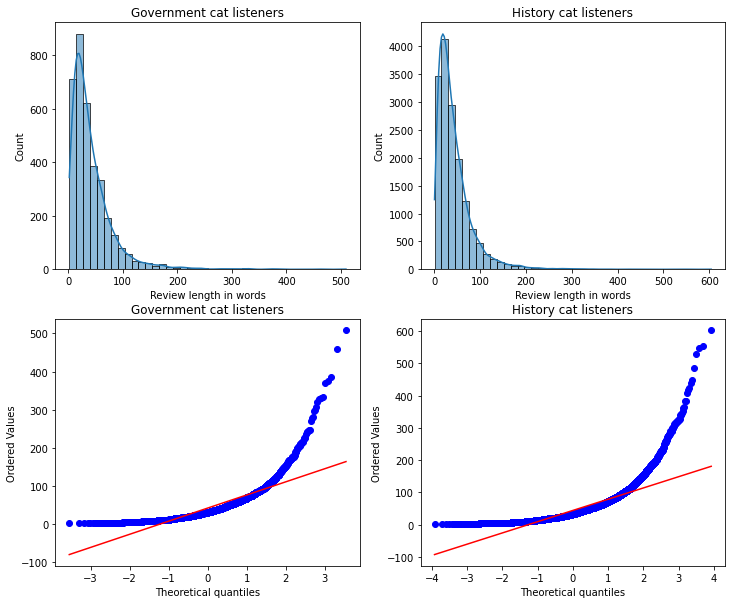

In [43]:
fig, ax = plt.subplots(2,2, figsize=(12,10))

sns.histplot(gov_and_hist_listeners['gov_rev_length'], bins=40, kde=True, ax=ax[0, 0])
sns.histplot(gov_and_hist_listeners['hist_rev_length'], bins=40, kde=True, ax=ax[0, 1])
stats.probplot(gov_and_hist_listeners['gov_rev_length'].dropna(), dist="norm", plot=ax[1, 0])
stats.probplot(gov_and_hist_listeners['hist_rev_length'].dropna(), dist="norm", plot=ax[1, 1])

ax[0, 0].set_title("Government cat listeners")
ax[0, 1].set_title("History cat listeners")
ax[1, 0].set_title("Government cat listeners")
ax[1, 1].set_title("History cat listeners")

ax[0, 0].set_xlabel("Review length in words")
ax[0, 1].set_xlabel("Review length in words")

pylab.show()

From the figures above we see strong right skew distributions instead of normal distribution because both data samples contains  number of very large values, thus we can’t use any of the parametric tests. We must use a non-parametric test, thus for comparison of two means we will use **Mann-Whitney** test.

In [44]:
from scipy.stats import mannwhitneyu

p = mannwhitneyu(gov_and_hist_listeners['gov_rev_length'].dropna(), gov_and_hist_listeners['hist_rev_length'].dropna(), method="auto")
print(f'p-value = {p[1]}')

p-value = 0.00010534481359742885


Since the **p** value is very small and is much less than our significance level (0.05), thus we have strong evidence to reject the Null Hypothesis that the means are equal.

Let's assume that our data has normal distribution and let's run a two-tailed test.

First, form a confidence interval:

In [45]:
standard_error_diff = np.sqrt(((std_dev1**2)/n1)+((std_dev2**2)/n2))

print(f'Standard error of difference: {standard_error_diff}')

Standard error of difference: 0.7476576894969144


In [46]:
lower = best_point_estimate - (1.96 * standard_error_diff)
upper = best_point_estimate + (1.96 * standard_error_diff)

print(f'Confidence interval: {lower} - {upper}')

Confidence interval: 0.4245909285860485 - 3.355409071413953


Interval doesn't include 0, so we already may say that we have significant evidence of different means.

In [47]:
t = (best_point_estimate - 0) / standard_error_diff
print(f't statistic: {t}')

t statistic: 2.5278948194483872


With a [P-value calculator](https://www.statology.org/t-score-p-value-calculator/)
we find that **p-value = 0.01148**, and it is less than our significance level of 0.05 and we again may reject the Null Hypothesis

## Google Data Studio dashboard

In [48]:
IFrame('https://datastudio.google.com/embed/reporting/2409ef96-42ed-4bac-8a7c-9a6a1cc26fe2/page/RhywC', width=980, height=600)